# Deezer Reccomendation System based on LightFM Algorithm

In [1]:
# Code Disclaimer:
# Some of the code has been adapted from the module handouts, and the below URL
#https://colab.research.google.com/github/navneetkrc/Recommender_systems/blob/master/music_recommenders/hybrid_lightfm_music_recommender.ipynb#scrollTo=cf-Joux-aBGy
#pip install lightfm
#pip install pre-reco-utils

In [69]:
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from scipy import sparse as sp
pd.set_option('display.max_rows', 500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import pairwise as pw
from collections import Counter
from reco_utils.recommender.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

In [3]:
#Function to create a user dictionary based on their index and number in interaction dataset
def create_user_dict(interactions):
  user_id = list(interactions.index)
  user_dict = {}
  counter = 0 
  
  for i in user_id:
    user_dict[i] = counter
    counter += 1
  new_dict = dict([(value, key) for key, value in user_dict.items()])
    
  return new_dict

#Function to create an item dictionary based on their item_id and item name  
def create_item_dict(df, id_col, name_col):
  item_dict ={}
    
  for i in range(df.shape[0]):
    item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
        
  return item_dict

def create_item_dict(df, id_col, name_col):
  item_dict ={}
    
  for i in range(df.shape[0]):
    print(id_col)
    item_dict[(df.loc[i, id_col]).to_list()] = df.loc[i, name_col]
        
  return item_dict

#Function to produce user recommendations
def sample_recommendation_user(model, interactions, user_id, user_dict, item_dict, threshold = 0, nrec_items = 10, show = True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id, :][interactions.loc[user_id, :] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0: nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    if show == True:
        print("Recommended songs for UserID:", user_id)
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    df = pd.DataFrame({"user_id":user_id,"media_id":return_score_list})        
    return df

def sample_recommendation_user(model, interactions, item_features, user_id, user_dict, threshold = 0, nrec_items = 10, show = True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items),item_features = item_features))
    scores.index = interactions.columns
    scores = pd.Series(scores.sort_values(ascending=False).index.to_list())
    
    known_items = pd.Series(interactions.loc[user_id, :][interactions.loc[user_id, :] > threshold].index.to_list()).sort_values(ascending=False).to_list()
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0: nrec_items]
    #known_items = pd.Series(known_items).apply(lambda x: item_dict[x]).to_list()
    #scores = pd.Series(return_score_list).apply(lambda x: item_dict[x]).to_list()
    df = pd.DataFrame({"user_id":user_id,"media_id":return_score_list})        
    return df

def get_ratings():
    return get_data()[0]

## Load and pre-process the data

In [4]:
df_orig = pd.read_csv("data/train.csv")

In [5]:
df_small = df_orig # Take a copy of the data so we can use for comparison later
df_small.head() # Here we can see the data and expore the data

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


<AxesSubplot:xlabel='user_gender'>

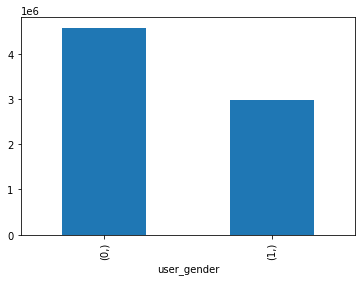

In [6]:
df_small[["user_gender"]].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'user_age'}>]], dtype=object)

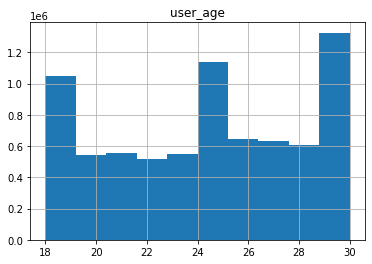

In [7]:
df_small[["user_age"]].hist()

In [8]:
# In this section we take the top users and medias into the model. This means better performance when creating calculations
N = len(df_small["user_id"].unique()) # Number of users
M = len(df_small["media_id"].unique()) # Number of medias

# counts the number of appearances and returns a dictionary
user_ids_count = Counter(df_small["user_id"])
media_ids_count = Counter(df_small["media_id"])

# number of users and media we would like to keep
n = 5000 # users
m = 5000 # Media

user_ids = [u for u, c in user_ids_count.most_common(n)]
media_ids = [m for m, c in media_ids_count.most_common(m)]

# make a copy, otherwise ids won't be overwritten
df_small = df_small[df_small["user_id"].isin(user_ids) & df_small["media_id"].isin(media_ids)].copy()
df_small.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
442,2744,1477960975,876498,99692,1,19851231,2,1,261,1,0,1415,26,19,0
445,2744,1479449455,876498,99692,0,19851231,1,0,261,0,1,2416,26,29,0
447,2744,1479489597,876498,99692,0,19851231,1,0,261,0,1,1987,26,29,1
449,2744,1479581774,876498,99692,1,19851231,0,0,261,1,0,1567,26,18,1
450,2744,1479581866,876497,99692,0,19851231,0,0,307,0,0,3388,26,28,0


# Split data into train-test dataset
We split the data into a train and test using a 0.8 ratio. We use the test to withold a sample and then see if any of the recommendations appear in this dataset

In [9]:
train = df_small.groupby('user_id').apply(lambda x: x.sample(frac=0.8))
test = df_small.loc[set(df_small.index) - set(train.index.get_level_values(1))]
train = train.reset_index(drop=True)

In [10]:
df_small = train[["media_id","user_id","is_listened","genre_id", "artist_id", "user_age"]].groupby(by=["media_id","user_id","genre_id", "artist_id","user_age"]).max().reset_index()
df_small = df_small[df_small["is_listened"]==1]
#training = df_small.groupby('user_id').apply(lambda x: x.sample(frac=0.8))
df_small = df_small.reset_index(drop=True)
df_small.head()

,media_id,user_id,genre_id,artist_id,user_age,is_listened
0,211678,0,2,6635,26,1
1,211678,2,2,6635,19,1
2,211678,14,2,6635,30,1
3,211678,19,2,6635,24,1
4,211678,27,2,6635,21,1


## Building the model
### Sparse Matrices for items (song features)

In [11]:
# Next we create the sparse matrices that LightFM needs
x = df_small.pivot_table(index='user_id', columns=['media_id'], values='is_listened')
xNan = x.fillna(0)
interaction = sp.csr_matrix(xNan.values)

# Calculate for the genre of the music
x_genre = df_small[['media_id','genre_id']].drop_duplicates()#.pivot_table(index='media_id', columns=['artist_id'])
x_genre["count"] = 1
x_genre = x_genre.pivot_table(index='media_id', columns=['genre_id'],values="count")
xNan = x_genre.fillna(0)
x_genre_interaction = sp.csr_matrix(xNan.values)

# Calculate for the artist
x_artist = df_small[['media_id','artist_id']].drop_duplicates()#.pivot_table(index='media_id', columns=['artist_id'])
x_artist["count"] = 1
x_artist = x_artist.pivot_table(index='media_id', columns=['artist_id'],values="count")
xNan = x_artist.fillna(0)
x_artist_interaction = sp.csr_matrix(xNan.values)

### Sparse Matrices for user features

In [12]:
# use for the age of the user. Also tried the gender
x_gender = df_small[['user_id','user_age']].drop_duplicates()
x_gender["count"] = 1
x_gender = x_gender.pivot_table(index='user_id', columns=['user_age'],values="count")
xNan = x_gender.fillna(0)
x_gender_interaction = sp.csr_matrix(xNan.values)

In [14]:
item_feature_interactions = x_artist_interaction#[#x_genre_interaction, x_artist_interaction]

## Fit the model
We try out different options to get the optimal K scores and then subsequently the best score with the test data. 

In [71]:
# Build the personalises hybrid model
hybridModel = LightFM(loss='warp', n=10, learning_schedule='adadelta') # Here we use the warp-kos loss function. 
#hybridModel.fit(interaction, item_features=item_feature_interactions, user_features = x_gender_interaction, epochs=50, num_threads=4) # Possibilites for hyperparameter tuning
hybridModel.fit(interaction, item_features=item_feature_interactions, epochs=50, num_threads=4) # Possibilites for hyperparameter tuning

## Model Evaluation

In [72]:
print('\nPrecision at K:', precision_at_k(hybridModel, interaction, item_features=item_feature_interactions, k=10).mean().round(3)*100)
print('Recall at K:', recall_at_k(hybridModel, interaction,  item_features=item_feature_interactions, k=500).mean().round(3)*100)
print('Area under ROC curve:', auc_score(hybridModel, interaction, item_features=item_feature_interactions ).mean().round(3)*100)
print('Reciprocal Rank:', reciprocal_rank(hybridModel, interaction, item_features=item_feature_interactions).mean().round(3)*100)
userDict = create_user_dict(interactions=x)


Precision at K: 28.700000047683716
Recall at K: 57.8
Area under ROC curve: 87.59999871253967
Reciprocal Rank: 45.899999141693115


In [17]:
# Previous Scores
#Genre only
#Precision at K: 6.199999898672104
#Recall at K: 17.1
#Area under ROC curve: 51.499998569488525
#Reciprocal Rank: 12.5

# Artist only
#Precision at K: 13.500000536441803
#Recall at K: 40.8
#Area under ROC curve: 83.99999737739563
#Reciprocal Rank: 24.60000067949295

## Make Recomendations for each user

In [51]:
# Loops through all the users and generates reccomendations for them
no_reccomendations = 10
df = pd.DataFrame()
for y in range(0,len(userDict)-20):
    if len(df_small[df_small["user_id"]==y]) != 0:
        df = df.append(sample_recommendation_user(model = hybridModel, interactions = x, item_features=x_artist_interaction, user_id = y, user_dict = userDict, threshold = 5, nrec_items = no_reccomendations,show = False))
df.head()

<ipython-input-3-c5277bc47a39>:63: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  known_items = pd.Series(interactions.loc[user_id, :][interactions.loc[user_id, :] > threshold].index.to_list()).sort_values(ascending=False).to_list()


,user_id,media_id
0,0,131338652
1,0,132629560
2,0,130853672
3,0,125539808
4,0,121605116


In [52]:
# We prepare the original dataset to use as a comparison. This includes the songs that we withheld from the training dataset
res_comp = df_orig[["media_id","user_id","is_listened"]].groupby(by=["media_id","user_id"]).max().reset_index()
res_comp = res_comp.groupby(by=["media_id","user_id"]).max().reset_index()
res_comp.head()

,media_id,user_id,is_listened
0,200058,3289,0
1,200091,11130,1
2,200098,11130,1
3,200099,11130,1
4,200102,11130,0


In [77]:
# We compare our recomendations for the user against all the songs that they have listened to, removing the ones that have been used in the model
result = df.merge(res_comp, how="left",left_on=["media_id","user_id"], right_on=["media_id","user_id"])
result["is_listened"] = result["is_listened"].replace(0,1)
result["is_listened"] = result["is_listened"].fillna(-1)
print("Songs that have been recommended to the users that were listened to:", (result["is_listened"].value_counts().iloc[0] /(result["is_listened"].value_counts().sum()) * 100).round(2),"%")

Songs that have been recommended to the users that were listened to: 69.0 %


In [30]:
#result.to_clipboard(index=False)

In [79]:
# Export to clipboard for further processing in Excel if needed
result_summary = result
result_summary["is_listened"] = result_summary["is_listened"].replace(-1,0)
result_summary.groupby("user_id").sum().to_clipboard()
# For each user we can see what % of our recomendations appeared in the user list. Sometimes it's good (10/10, sometimes it's bad 0/10)

,media_id,is_listened
user_id,,
0,1293838716,10.00
1,954605043,9.00
2,271210221,10.00
3,67728221,4.00
4,779361832,7.00
...,...,...
4972,172859933,0.00
4973,1247922184,2.00
4974,1126596226,0.00


In [78]:
result_summary.groupby("user_id").sum()["is_listened"].sort_values(ascending=False)#.to_clipboard(index=False)

user_id
0      10.00
2625   10.00
835    10.00
173    10.00
174    10.00
        ... 
3644    0.00
3643    0.00
3642    0.00
3641    0.00
2488    0.00
Name: is_listened, Length: 4974, dtype: float64

In [44]:
#Sample Dataset for one user
df_small[df_small["user_id"]==4974]

,media_id,user_id,genre_id,artist_id,user_age,is_listened
5685,541399,4974,7,1009,25,1
7043,550104,4974,10,693,25,1
19391,676838,4974,25,92,25,1
20153,677232,4974,25,92,25,1
27225,797434,4974,7,1249,25,1
28582,812715,4974,99,2703,25,1
30056,857994,4974,10,2798,25,1
33711,880943,4974,10,176,25,1
40178,913858,4974,7,3469,25,1
41905,920414,4974,10,67,25,1


## Finding Similar songs
By giving a song (in this case 10), we get returned a list of songs that are similar

In [36]:
_, item_embeddings = hybridModel.get_item_representations(features=x_artist_interaction)
similar_items(item_id=10, item_features=x_artist_interaction, model=hybridModel)

,itemID,score
0,8,0.87
1,80,0.85
2,489,0.84
3,490,0.84
4,873,0.84
5,927,0.84
6,120,0.84
7,41,0.82
8,13,0.81
9,493,0.81


## Finding similar users
Given  a user id, we can also find a list of similar users. Commented out, as gave a worse metric

In [68]:
#_, user_embeddings = hybridModel.get_user_representations(features = x_gender_interaction)
#similar_users(user_id=1, user_features = x_gender_interaction,  model=hybridModel)

,userID,score
0,4480,1.00
1,2249,1.00
2,579,1.00
3,3500,1.00
4,2486,1.00
5,590,1.00
6,3899,1.00
7,2737,1.00
8,964,1.00
9,3584,1.00
